In [ ]:
import sys
print(sys.version)

3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Observation data

obs_data = [1120, 1160, 963, 1210, 1160, 1160, 813, 1230, 1370, 1140, 995, 935, 1110, 994, 1020, 960, 1180, 799, 958, 1140, 1100, 1210, 1150, 1250, 1260, 1220, 1030, 1100, 774, 840, 874, 694, 940, 833, 701, 916, 692, 1020, 1050, 969, 831, 726, 456, 824, 702, 1120, 1100, 832, 764, 821, 768, 845, 864, 862, 698, 845, 744, 796, 1040, 759, 781, 865, 845, 944, 984, 897, 822, 1010, 771, 676, 649, 846, 812, 742, 801, 1040, 860, 874, 848, 890, 744, 749, 838, 1050, 918, 986, 797, 923, 975, 815, 1020, 906, 901, 1170, 912, 746, 919, 718, 714, 740]



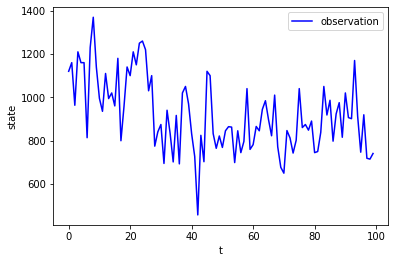

In [ ]:
obs_data_str = \
'1120 1160  963 1210 1160 1160  813 1230 1370 1140  995  935 1110  994 1020  960 1180  799  958 1140 1100 \
1210 1150 1250 1260 1220 1030 1100  774  840  874  694  940  833  701  916  692 1020 1050  969  831  726 \
456  824  702 1120 1100  832  764  821  768  845  864  862  698  845  744  796 1040  759  781  865  845 \
944  984  897  822 1010  771  676  649  846  812  742  801 1040  860  874  848  890  744  749  838 1050 \
918  986  797  923  975  815 1020  906  901 1170  912  746  919  718  714  740'

obs_data = [eval(obs_datum_str) for obs_datum_str in obs_data_str.split(' ') if obs_datum_str is not '']
print('obs_data =', obs_data)
print()

plt.xlabel('t')
plt.ylabel('state')
plt.plot(range(len(obs_data)), obs_data, label='observation', color='blue')
plt.legend(loc='upper right')

# Local level model

In a local level model, the space state model (motion equation and measurement equation)

\begin{align}
x_t &= F_t x_{t-1} + B_t u_t + \omega_t 
\\
z_t &= H_t x_t + \nu_t
\end{align}

would be

\begin{align}
x_t &= x_{t-1} + \omega_t 
\\
z_t &= x_t + \nu_t
\end{align}

This means that the current state $x_t$ is same as the previous sate $x_{t-1}$ (and there is no control command $u_t$) and the current observation $z_t$ is same as the current state $x_t$ (which means we use a magical sensor that can measure the state directly), but including process noise $\omega_t$ and measurement noise $\nu_t$. 

Therefore, the motion predict phase

\begin{align}
\hat{x}_{t|t-1} &= F_t \hat{x}_{t-1|t-1} + B_t u_t
\\
P_{t|t-1} &= F_t P_{t-1|t-1} F_t^T + Q_t
\\
\end{align}

would be

\begin{align}
\hat{x}_{t|t-1} &= \hat{x}_{t-1|t-1}
\\
P_{t|t-1} &= P_{t-1|t-1} + Q_t
\\
\end{align}

and the measurement update phase

\begin{align}
K_t &= \frac{P_{t|t-1} H_t^T}{H_t P_{t|t-1} H_t^T + R_t}
\\
\\
\hat{x}_{t|t} &= \hat{x}_{t|t-1} + K_t (z_t - H_t \hat{x}_{t|t-1})
\\
P_{t|t} &= (1 - K_t H_t) P_{t|t-1}
\\
\end{align}

would be

\begin{align}
K_t &= \frac{P_{t|t-1}}{P_{t|t-1} + R_t}
\\
\\
\hat{x}_{t|t} &= \hat{x}_{t|t-1} + K_t (z_t - \hat{x}_{t|t-1})
\\
P_{t|t} &= (1 - K_t) P_{t|t-1}
\\
\end{align}

# Kalman Filter

In [ ]:
def MotionPredict(x_prev_post, P_prev_post, var_process):
    ### x_{t|t-1} = x_{t-1|t-1}
    x_curr_prior = x_prev_post

    ### P_{t|t-1} = P_{t-1|t-1} + Q_t
    P_curr_prior = P_prev_post + var_process

    return x_curr_prior, P_curr_prior

In [ ]:
def MeasurementUpdate(x_curr_prior, P_curr_prior, var_measure, obs_datum):
    ### K_t = P_{t|t-1} / P_{t|t-1} + R_t
    kalman_gain = P_curr_prior / (P_curr_prior + var_measure)

    ### x_{t|t} = x_{t|t-1} + K_t * (z_t - x_{t|t-1})
    x_curr_post = x_curr_prior + kalman_gain*(obs_datum - x_curr_prior)

    ### P_{t|t} = (1 - K_t) * P_{t|t-1}
    P_curr_post = (1 - kalman_gain)*P_curr_prior

    return x_curr_post, P_curr_post

In [ ]:
def KalmanFilter(x_init, P_init, var_process, var_measure, obs_data):
    xs_post = []
    Ps_post = []

    x_prev_post = x_init
    P_prev_post = P_init
    
    for t in range(len(obs_data)):
        x_curr_prior, P_curr_prior = MotionPredict(x_prev_post, P_prev_post, var_process)
        x_curr_post, P_curr_post = MeasurementUpdate(x_curr_prior, P_curr_prior, var_measure, obs_data[t])

        xs_post.append(x_curr_post)
        Ps_post.append(P_curr_post)
    
        x_prev_post = x_curr_post
        P_prev_post = P_curr_post

    return xs_post, Ps_post

In [ ]:
x_init = 1000
P_init = 1000
var_process = 1000
var_measure = 10000

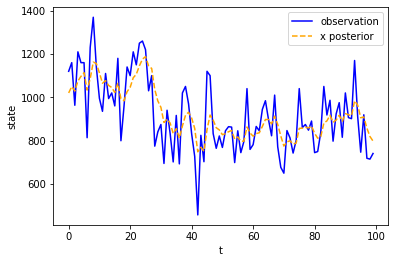

In [ ]:
xs_post, _ = KalmanFilter(x_init, P_init, var_process, var_measure, obs_data)

plt.xlabel('t')
plt.ylabel('state')
plt.plot(range(len(obs_data)), obs_data, label='observation', color='blue')
plt.plot(range(len(obs_data)), xs_post, label='x posterior', linestyle='dashed', color='orange')
plt.legend(loc='upper right')

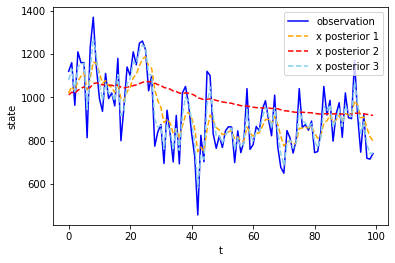

In [ ]:
xs_post1, _ = KalmanFilter(x_init, P_init, var_process, var_measure, obs_data)
xs_post2, _ = KalmanFilter(x_init, P_init, var_process/1000, var_measure, obs_data)
xs_post3, _ = KalmanFilter(x_init, P_init, var_process, var_measure/10, obs_data)

plt.xlabel('t')
plt.ylabel('state')
plt.plot(range(len(obs_data)), obs_data, label='observation', color='blue')
plt.plot(range(len(obs_data)), xs_post1, label='x posterior 1', linestyle='dashed', color='orange')
plt.plot(range(len(obs_data)), xs_post2, label='x posterior 2', linestyle='dashed', color='red')
plt.plot(range(len(obs_data)), xs_post3, label='x posterior 3', linestyle='dashed', color='skyblue')
plt.legend(loc='upper right')

# Reference

* [カルマンフィルタの考え方](https://logics-of-blue.com/kalman-filter-concept/)